# Focal loss vs. cross-entropy loss

In [117]:
!pip install -q tabulate


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In this notebook we study calibration of a model trained with a focal and a cross-entropy loss. While the cross-entropy loss is the gold standard for training classification tasks that want to maximize accuracy, it has been shown [Mukhoti et al., 2020](https://proceedings.neurips.cc/paper/2020/file/aeb7b30ef1d024a76f21a1d40e30c302-Paper.pdf) that the focal loss tends to achieve better calibration errors. In this notebook we compare the two on the [MNIST corrupted](https://www.tensorflow.org/datasets/catalog/mnist_corrupted) data set, for a simple LeNet-5 deep learning model. The hyper-parameter of the focal loss is kept to the default `gamma=2`.

## Download, split and process the data

First, we download the data from TensorFlow, and split them into training, validation and test set.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


def download(split_range, shuffle=False):
    ds = tfds.load(
        name="mnist_corrupted",
        split=f"train[{split_range}]",
        as_supervised=True,
        shuffle_files=True,
    ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    if shuffle:
        ds = ds.shuffle(10, reshuffle_each_iteration=True)
    return ds.batch(128).prefetch(1)


train_data_loader, val_data_loader, test_data_loader = (
    download(":80%", shuffle=True),
    download("80%:90%"),
    download("90%:"),
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


We then convert the data loaders into something that Fortuna can work with.

In [2]:
from fortuna.data import DataLoader

train_data_loader = DataLoader.from_tensorflow_data_loader(train_data_loader)
val_data_loader = DataLoader.from_tensorflow_data_loader(val_data_loader)
test_data_loader = DataLoader.from_tensorflow_data_loader(test_data_loader)

## Define and train the model

We define a calibration model and train it with both cross entropy and focal loss. We repeat the task several times to capture the variability of the calibration error. During training, we monitor Brier score and accuracy. Early stopping is enabled.

In [63]:
from fortuna.loss.classification import cross_entropy_loss_fn, focal_loss_fn
from fortuna.metric.classification import compute_counts_confs_accs
from fortuna.calibration.calib_model import CalibClassifier, Config, Monitor, Optimizer
from fortuna.model import LeNet5
from fortuna.metric.classification import brier_score, accuracy

def brier(preds, uncertainties, targets): 
    return brier_score(uncertainties, targets)

def acc(preds, uncertainties, targets): 
    return accuracy(preds, targets)

calib_model = CalibClassifier(model=LeNet5(output_dim=10))

losses = {"cross entropy": cross_entropy_loss_fn, "focal loss": focal_loss_fn}

test_inputs_loader = test_data_loader.to_inputs_loader()
all_confs, all_accs, all_eces, = {}, {}, {}

n_iter = 30
    
for i, (name, loss) in enumerate(losses.items()):    
    confs, accs, eces = [], [], []
    for j in range(n_iter):
        status = calib_model.calibrate(
            train_data_loader, 
            val_data_loader=val_data_loader,
            loss_fn=loss,
            config=Config(
                monitor=Monitor(early_stopping_patience=2, metrics=(brier, acc))
            )
        )

        means = calib_model.predictive.mean(test_inputs_loader)
        modes = calib_model.predictive.mode(test_inputs_loader)
        eces.append(expected_calibration_error(modes, means, targets))
        counts, _confs, _accs = compute_counts_confs_accs(modes, means, targets)
        confs.append(_confs), accs.append(_accs)
    all_confs[name], all_accs[name], all_eces[name] = confs, accs, eces

Epoch: 6 | loss: 0.01396 | brier: 0.00609 | acc: 1.0:   5%|████▉                                                                                             | 5/100 [00:30<09:43,  6.14s/it]
Epoch: 5 | loss: 0.03818 | brier: 0.01845 | acc: 0.98438:   4%|███▊                                                                                          | 4/100 [00:25<10:08,  6.34s/it]
Epoch: 5 | loss: 0.01545 | brier: 0.00617 | acc: 1.0:   4%|███▉                                                                                              | 4/100 [00:24<09:50,  6.15s/it]
Epoch: 6 | loss: 0.01839 | brier: 0.01182 | acc: 0.99219:   5%|████▋                                                                                         | 5/100 [00:29<09:23,  5.93s/it]
Epoch: 7 | loss: 0.01212 | brier: 0.00542 | acc: 0.99219:   6%|█████▋                                                                                        | 6/100 [00:35<09:08,  5.84s/it]
Epoch: 6 | loss: 0.02762 | brier: 0.01479 | acc: 0

Epoch: 8 | loss: 0.00985 | brier: 0.01882 | acc: 0.98438:   7%|██████▌                                                                                       | 7/100 [00:47<10:30,  6.78s/it]
Epoch: 5 | loss: 0.00194 | brier: 0.00824 | acc: 1.0:   4%|███▉                                                                                              | 4/100 [00:30<12:23,  7.75s/it]
Epoch: 6 | loss: 0.00855 | brier: 0.02012 | acc: 0.99219:   5%|████▋                                                                                         | 5/100 [00:36<11:39,  7.37s/it]
Epoch: 7 | loss: 0.02463 | brier: 0.03412 | acc: 0.97656:   6%|█████▋                                                                                        | 6/100 [00:42<10:58,  7.00s/it]
Epoch: 6 | loss: 0.04482 | brier: 0.04599 | acc: 0.96875:   5%|████▋                                                                                         | 5/100 [00:36<11:25,  7.21s/it]
Epoch: 5 | loss: 0.01154 | brier: 0.01647 | acc: 0

## Expected calibration error and reliablity plot

We print average and standard deviation of the expected calibration error (ECE) for each loss. Finally, we plot a reliability diagram for each training run and each loss.

In [116]:
import numpy as np
from tabulate import tabulate
headers = ["loss / ECE", "mean", "std"]
table = [*[[name, np.mean(all_eces[name]), np.std(all_eces[name])] for name in losses.keys()]]
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤════════════╕
│ loss / ECE    │       mean │        std │
╞═══════════════╪════════════╪════════════╡
│ cross entropy │ 0.00912544 │ 0.00212543 │
├───────────────┼────────────┼────────────┤
│ focal loss    │ 0.0149724  │ 0.00774826 │
╘═══════════════╧════════════╧════════════╛


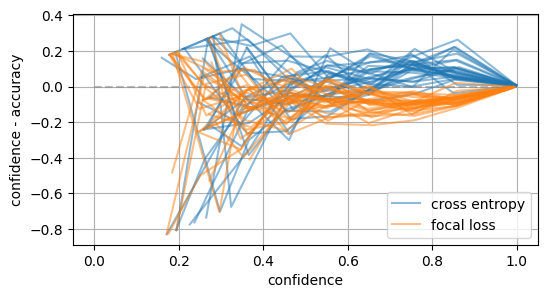

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
for i, name in enumerate(losses.keys()):
    plt.plot([0, 1], [0, 0], linestyle="--", color="gray", alpha=0.3, label='_nolegend_')
    for j, (confs, accs) in enumerate(zip(np.array(all_confs[name]), np.array(all_accs[name]))):
        idx = np.where(confs)[0]
        plt.plot(confs[idx], confs[idx] - accs[idx], c=f"C{i}", alpha=0.5, label='_nolegend_' if j > 0 else name)
plt.grid()
plt.xlabel("confidence")
plt.ylabel("confidence - accuracy")
plt.legend(loc="lower right");

For this simple experiment, the two losses perform similarly well, as the respective mean ECEs are not significantly different. We can notice though that the cross-entropy loss appears slightly overconfident, while the focal loss is slight underconfidence. This aligns with the derivation in [Mukhoti et al., 2020](https://proceedings.neurips.cc/paper/2020/file/aeb7b30ef1d024a76f21a1d40e30c302-Paper.pdf), showing that, compared to the cross-entropy loss, the focal loss avoids overconfidence as it intrinsically maximizes an entropy term.